In [11]:
import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import functools

from load_mnist import download_mnist_if_needed, load_images, load_labels

import matplotlib.pyplot as plt


data_dir = "./data"
device = jax.devices('cpu')[0]

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : TFRT_CPU_0


In [12]:
def preprocess(x):
    x = x.astype(np.float32) / 255.0    # normalize to [0, 1]
    x = x > 0.5                         # binarize
    x = x.reshape(x.shape[0], -1)       # flatten for RBM
    x = jnp.array(x, dtype=jnp.float32) # use jax numpy array of dtype float32, because RBM has float32 params
    return x


data_paths = download_mnist_if_needed(root=data_dir, train_only=True)
x_train_raw = load_images(data_paths['train_images'])
y_train = load_labels(data_paths['train_labels'])

x_train = preprocess(x_train_raw)
print(f"x_train dtype: {x_train.dtype}, shape: {x_train.shape}")
print(f"x_train min: {x_train.min()}, max: {x_train.max()}")

x_train dtype: float32, shape: (60000, 784)
x_train min: 0.0, max: 1.0


In [13]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, rng: PRNGKey) -> (jnp.ndarray, jnp.ndarray):
        # in flax, __call__ is the main computation to be differentiated.

        # initialize parameters in @nn.compact style:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        params = {"W": W, "b": b, "c": c}

        # gibbs sampling only refines the fantasy particles, we are actually not interested in the gradients
        v_k, key = self._gibbs_sample(params, v_persistent, rng, k=self.k)
        v_k = jax.lax.stop_gradient(v_k)

        # we are interested in the gradients of the free energy w.r.t. the parameters
        free_energy_data  = self._free_energy(params, data_batch)
        free_energy_model = self._free_energy(params, v_k)

        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        # since this is a pcd loss function, we also return the updated fantasy particles. and we also pass through the key
        # since JAX’s tree utilities flatten nested tuples we need to wrap the auxiliary variables in a container
        aux_vars = {"v_persistent": v_k, "key": key}

        return pcd_loss, aux_vars

    @staticmethod
    def _free_energy(params, v):
        W, b, c = params["W"], params["b"], params["c"]

        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, params, T=1.0):
        v, key = state
        W, b, c = params["W"], params["b"], params["c"]

        # splitting generates different random numbers for each step, one of them is passed on
        key, h_key, v_key = jax.random.split(key, 3)

        h_probs = jax.nn.sigmoid(v @ W + c)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_probs = jax.nn.sigmoid(h @ W.T + b)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(params, v_init, rng, k=1, T=1.0):
        # The fori_loop enables JIT compilation of loops. It basically unrolls the loop over the fixed length k.

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

In [14]:
class RBMTrainState(train_state.TrainState):
    """
    A value object bundling parameters and optimizer state for training.
    It has a few pre-defined fields to be used in the training loop.
    Since it is immutable, the training function needs to return a new instance after each update step.
    """
    pass


@functools.partial(jax.jit)
def train_step(state: RBMTrainState, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, key: PRNGKey):

    # only the 'params' argument remains a variable to be differentiated
    pcd_loss_fn = lambda params: state.apply_fn({'params': params}, data_batch, v_persistent, key)

    # since our pc_loss_fn also returns the updated fantasy particles, we need to use has_aux=True
    value_and_grad_fn = jax.value_and_grad(pcd_loss_fn, has_aux=True)
    (pcd_loss, aux_vars), pdc_loss_grads = value_and_grad_fn(state.params)

    # apply the gradients to the state, this actually updates the optimizer state
    new_state = state.apply_gradients(grads=pdc_loss_grads)
    v_persistent = aux_vars["v_persistent"]
    key = aux_vars["key"]

    return new_state, pcd_loss, v_persistent, key

In [15]:
# Instantiate the RBM model using the number of visible units from x_train and a chosen number of hidden units.
n_visible = x_train.shape[1]
n_hidden = 100  # you can adjust this number
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)

# Initialize the random key and create a mini-batch for training.
rng = PRNGKey(0)
batch_size = 64
data_batch = x_train[:batch_size]

# Initialize the persistent chain (here we use a random binarized array with the same shape as the batch)
rng, subkey = jax.random.split(rng)
v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=data_batch.shape).astype(jnp.float32)

# Initialize model parameters. Note that we pass two copies of rng: one for parameter init and one for the call.
params = rbm.init(rng, data_batch, v_persistent, rng)['params']

# Define an optimizer (Adam in this case) and create the training state.
optimizer = optax.adam(learning_rate=0.001)
state = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=optimizer)

# Run one training step.
state, pcd_loss, v_persistent, rng = train_step(state, data_batch, v_persistent, rng)

print("PCD Loss:", pcd_loss)
print("Updated persistent chain shape:", v_persistent.shape)

PCD Loss: 1.1661682
Updated persistent chain shape: (64, 784)


In [27]:
class DataLoader:
    def __init__(self, x, y, batch_size=128, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_samples = x.shape[0]

    def __iter__(self):
        indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(indices)
        for start in range(0, self.n_samples, self.batch_size):
            excerpt = indices[start:start + self.batch_size]
            yield self.x[excerpt], self.y[excerpt]

    def __len__(self):
        return -(-self.n_samples // self.batch_size)  # ceiling division




def train_rbm(state: RBMTrainState, train_loader, num_epochs: int, rng: PRNGKey, pcd_reset: int = 5, scheduler=None):
    metrics = {}

    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, (data, labels) in enumerate(train_loader):

            # reset the persistent chain every N batches
            if batch_idx % pcd_reset == 0:
                rng, subkey = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=data.shape).astype(jnp.float32)

            # Run one train step: train_step returns updated state, loss, new persistent chain, and new key.
            state, loss, v_persistent, rng = train_step(state, data, v_persistent, rng)
            total_loss += loss
            batch_count += 1

        avg_loss = total_loss / len(train_loader)
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics, rng
# --- TRAINING SETUP ---
batch_size    = 128
visible_units = 28 * 28
hidden_units  = 256
k_steps       = 1
lr            = 1e-3
num_epochs    = 40
pcd_reset     = 75        # reset persistent chain every N batches
weight_decay  = 1e-5      # if needed; see optax.add_decayed_weights
lr_decay      = 0.95      # not used explicitly here

# Instantiate the RBM with desired number of Gibbs steps.
rbm = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps)

# Create a random key and a mini-batch to initialize parameters. Jay requires one forward pass to initialize parameters.
rng = PRNGKey(0)
dummy_batch = x_train[:batch_size]
rng, subkey = jax.random.split(rng)
v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=dummy_batch.shape).astype(jnp.float32)
params = rbm.init(rng, dummy_batch, v_persistent, rng)['params']

train_loader = DataLoader(x_train, y_train, batch_size=batch_size, shuffle=True)


steps_per_epoch = -(-x_train.shape[0] // batch_size)
lr_schedule = optax.exponential_decay(init_value=lr, transition_steps=steps_per_epoch, decay_rate=lr_decay, staircase=True)
optimizer = optax.adam(learning_rate=lr_schedule)
state = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=optimizer)

state, metrics, rng = train_rbm(state, train_loader, num_epochs, rng, pcd_reset=pcd_reset, scheduler=lr_schedule)

Epoch [1/40] - Free Energy Loss: -84.9521
Epoch [2/40] - Free Energy Loss: -147.5348
Epoch [3/40] - Free Energy Loss: -226.5374
Epoch [4/40] - Free Energy Loss: -213.5051
Epoch [5/40] - Free Energy Loss: -189.7616
Epoch [6/40] - Free Energy Loss: -168.3109
Epoch [7/40] - Free Energy Loss: -108.6890
Epoch [8/40] - Free Energy Loss: -103.4832
Epoch [9/40] - Free Energy Loss: -81.6041
Epoch [10/40] - Free Energy Loss: -72.4993
Epoch [11/40] - Free Energy Loss: -66.2073
Epoch [12/40] - Free Energy Loss: -68.4737
Epoch [13/40] - Free Energy Loss: -65.2209
Epoch [14/40] - Free Energy Loss: -63.8241
Epoch [15/40] - Free Energy Loss: -58.2643
Epoch [16/40] - Free Energy Loss: -57.2664
Epoch [17/40] - Free Energy Loss: -54.4972
Epoch [18/40] - Free Energy Loss: -51.9996
Epoch [19/40] - Free Energy Loss: -51.5072
Epoch [20/40] - Free Energy Loss: -49.0235
Epoch [21/40] - Free Energy Loss: -48.5303
Epoch [22/40] - Free Energy Loss: -47.6722
Epoch [23/40] - Free Energy Loss: -45.4043
Epoch [24/40]

Text(0, 0.5, 'Free Energy Loss')

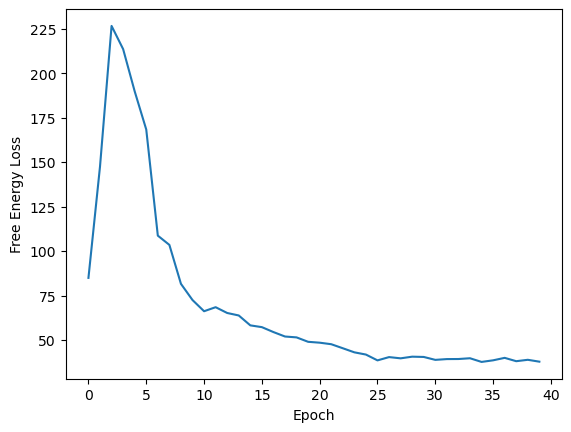

In [28]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")